# Importation des bibliothèques nécessaires
Importer les bibliothèques nécessaires, y compris pandas, numpy, scikit-learn, et matplotlib.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for plots
#sns.set(style="whitegrid")

import matplotlib.pyplot as plt
plt.style.use('ggplot')  # Appliquer le style ggplot


# Chargement des données
Charger les fichiers CSV HDFS_occurence_matrix_HDFS_train.csv, HDFS_occurence_matrix_HDFS_valid.csv, et HDFS_occurence_matrix_HDFS_test.csv dans des DataFrames pandas.

In [2]:
# Chargement des données
train_df = pd.read_csv('BGL_results/BGL_1M_train_sliding_window.csv')
valid_df = pd.read_csv('BGL_results/BGL_1M_valid_sliding_window.csv')
test_df = pd.read_csv('BGL_results/BGL_1M_test_sliding_window.csv')

# Afficher les premières lignes des DataFrames pour vérifier le chargement
print(train_df.head())
print(valid_df.head())
print(test_df.head())

             Timestamp  E1  E2  E3  E4  E5  E6  E7  E8  E9  ...  E293  E294  \
0  2005-06-23 18:44:50   0   0   2   0   0   0   0   0   0  ...     0     0   
1  2005-06-16 10:20:50   0   0   0   6  12   3   3   0   0  ...     0     0   
2  2005-06-14 15:36:20   0   0   1   1   1   1   1   0   0  ...     0     0   
3  2005-06-20 23:35:50   0   0   0   5   1   7   5   0   0  ...     0     0   
4  2005-06-16 11:26:50   0   0   1   6  14   6   3   0   0  ...     0     0   

   E295  E296  E297  E298  E299  E300  E301  Anomaly  
0     0     0     0     0     0     0     0     Fail  
1     0     0     0     0     0     0     0     Fail  
2     0     0     0     0     0     0     0     Fail  
3     0     0     0     0     0     0     0     Fail  
4     0     0     0     0     0     0     0     Fail  

[5 rows x 303 columns]
             Timestamp    E1  E2  E3  E4  E5  E6  E7  E8  E9  ...  E293  E294  \
0  2005-06-10 12:22:50     0   0   0   3   0  31   1   0   0  ...     0     0   
1  2005-0

# Analyse des variables et traitement des corrélations
Calculer la matrice de corrélation sur les variables indépendantes dans l'ensemble d'entraînement. Identifier et supprimer les variables fortement corrélées (corrélation > 0,9).

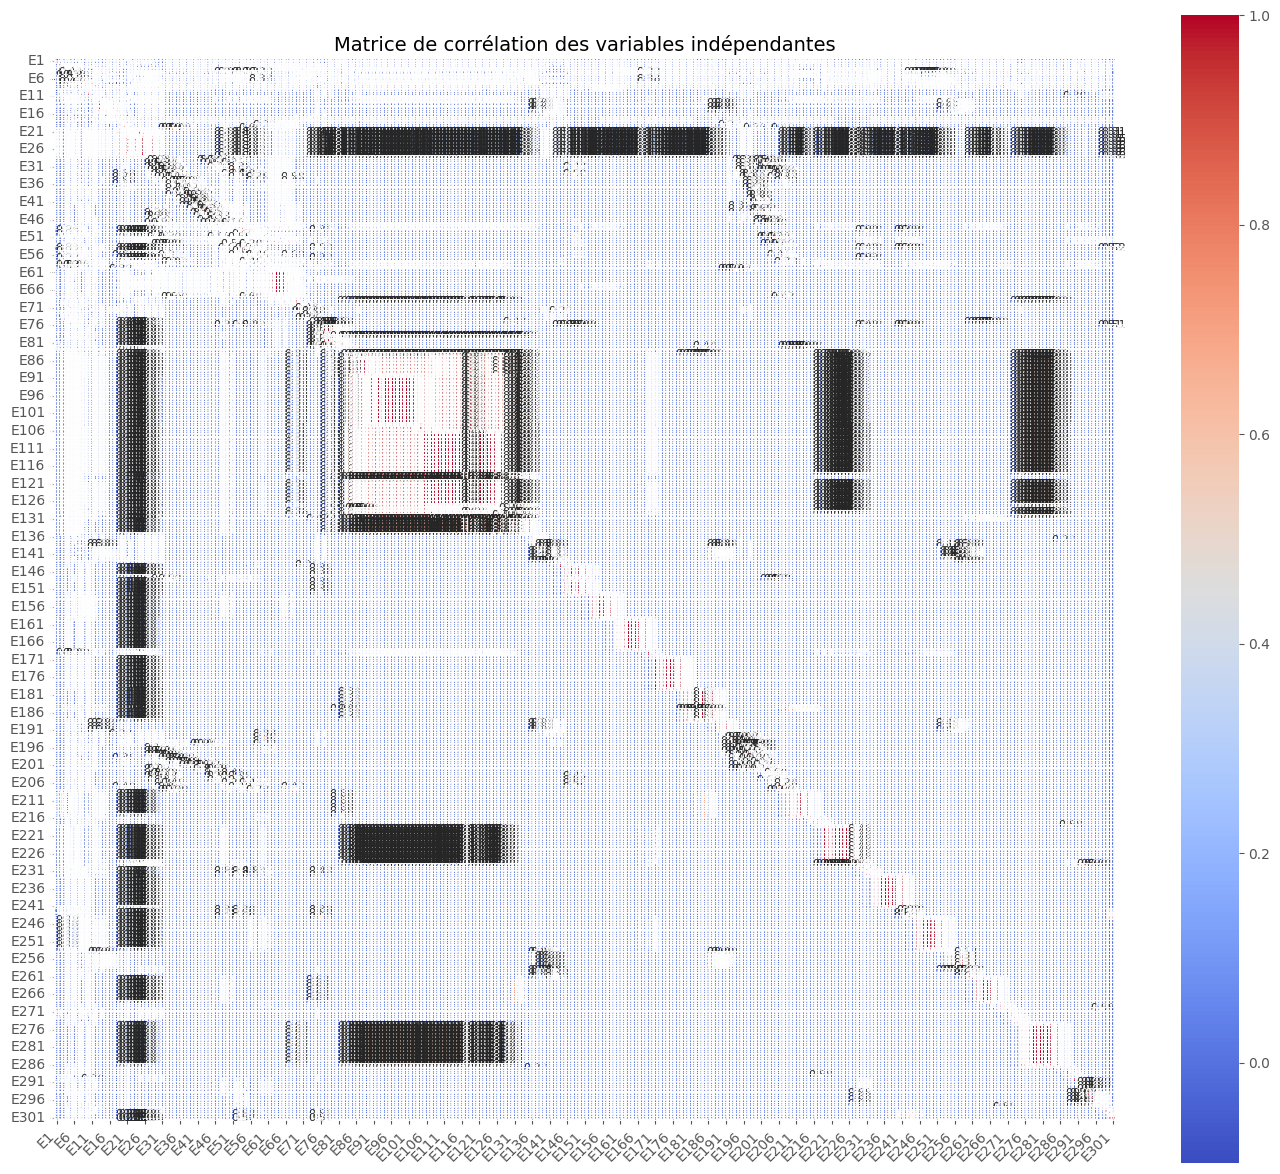

Variables supprimées en raison d'une forte corrélation: {'E80', 'E117', 'E132', 'E165', 'E281', 'E96', 'E158', 'E280', 'E122', 'E141', 'E216', 'E94', 'E268', 'E128', 'E68', 'E182', 'E115', 'E228', 'E261', 'E14', 'E62', 'E257', 'E293', 'E226', 'E65', 'E25', 'E125', 'E252', 'E168', 'E101', 'E61', 'E277', 'E187', 'E89', 'E46', 'E88', 'E149', 'E104', 'E286', 'E81', 'E7', 'E213', 'E267', 'E161', 'E272', 'E265', 'E210', 'E93', 'E87', 'E264', 'E27', 'E142', 'E164', 'E26', 'E126', 'E248', 'E95', 'E155', 'E232', 'E74', 'E174', 'E86', 'E55', 'E98', 'E134', 'E159', 'E276', 'E28', 'E64', 'E127', 'E129', 'E23', 'E120', 'E184', 'E241', 'E121', 'E183', 'E236', 'E172', 'E78', 'E66', 'E282', 'E212', 'E177', 'E156', 'E92', 'E179', 'E222', 'E223', 'E285', 'E227', 'E103', 'E263', 'E266', 'E147', 'E234', 'E108', 'E124', 'E283', 'E258', 'E152', 'E214', 'E175', 'E237', 'E133', 'E100', 'E215', 'E220', 'E224', 'E176', 'E157', 'E166', 'E167', 'E97', 'E90', 'E67', 'E106', 'E173', 'E146', 'E151', 'E63', 'E225', '

In [3]:
# Suppression des colonnes non indépendantes et calcul de la matrice de corrélation
correlation_matrix = train_df.drop(columns=['Timestamp', 'Anomaly']).corr()

# Affichage de la matrice de corrélation avec des ajustements pour éviter le chevauchement
plt.figure(figsize=(14, 12))  # Augmenter la taille du graphique
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    square=True, 
    annot_kws={"size": 8}  # Taille des annotations
)

# Ajuster l'alignement des étiquettes des axes
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotation des étiquettes sur l'axe x
plt.yticks(rotation=0, fontsize=10)  # Rotation des étiquettes sur l'axe y

plt.title('Matrice de corrélation des variables indépendantes', fontsize=14)
plt.tight_layout()  # Ajuste automatiquement les marges pour éviter les chevauchements
plt.show()

# Identification des variables fortement corrélées (corrélation > 0.9)
high_corr_var = set()
threshold = 0.9

# Parcourir les éléments de la matrice de corrélation
for i in range(len(correlation_matrix.columns)):
    for j in range(i):  # Éviter les doublons et la diagonale
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_var.add(colname)

# Suppression des variables fortement corrélées
train_df_reduced = train_df.drop(columns=high_corr_var)
valid_df_reduced = valid_df.drop(columns=high_corr_var)
test_df_reduced = test_df.drop(columns=high_corr_var)

# Affichage des variables supprimées
print(f"Variables supprimées en raison d'une forte corrélation: {high_corr_var}")

# Vérification des DataFrames réduits
print("Aperçu des DataFrames réduits :")
print(train_df_reduced.head())
print(valid_df_reduced.head())
print(test_df_reduced.head())

# Création des échantillons avec bootstrap
Utiliser le bootstrap pour créer des échantillons de l'ensemble d'entraînement. Chaque échantillon a la même taille que l'ensemble d'entraînement d'origine (avec remplacement).

Pour chaque échantillon bootstrap, entraîner un modèle de régression logistique sur l'ensemble d'entraînement. Valider ce modèle sur un ensemble de validation distinct.

Répéter les étapes de création d'échantillons bootstrap et de modélisation un nombre défini de fois. Stocker les performances (Précision, Rappel et AUC).


Performances moyennes pour Logistic Regression:
Accuracy moyenne: 0.9965
Precision moyenne: 0.9978
Recall moyenne: 0.9985
F1 moyenne: 0.9982
Roc_auc moyenne: 0.9925

Performances moyennes pour Random Forest:
Accuracy moyenne: 0.9997
Precision moyenne: 0.9998
Recall moyenne: 0.9998
F1 moyenne: 0.9998
Roc_auc moyenne: 1.0000


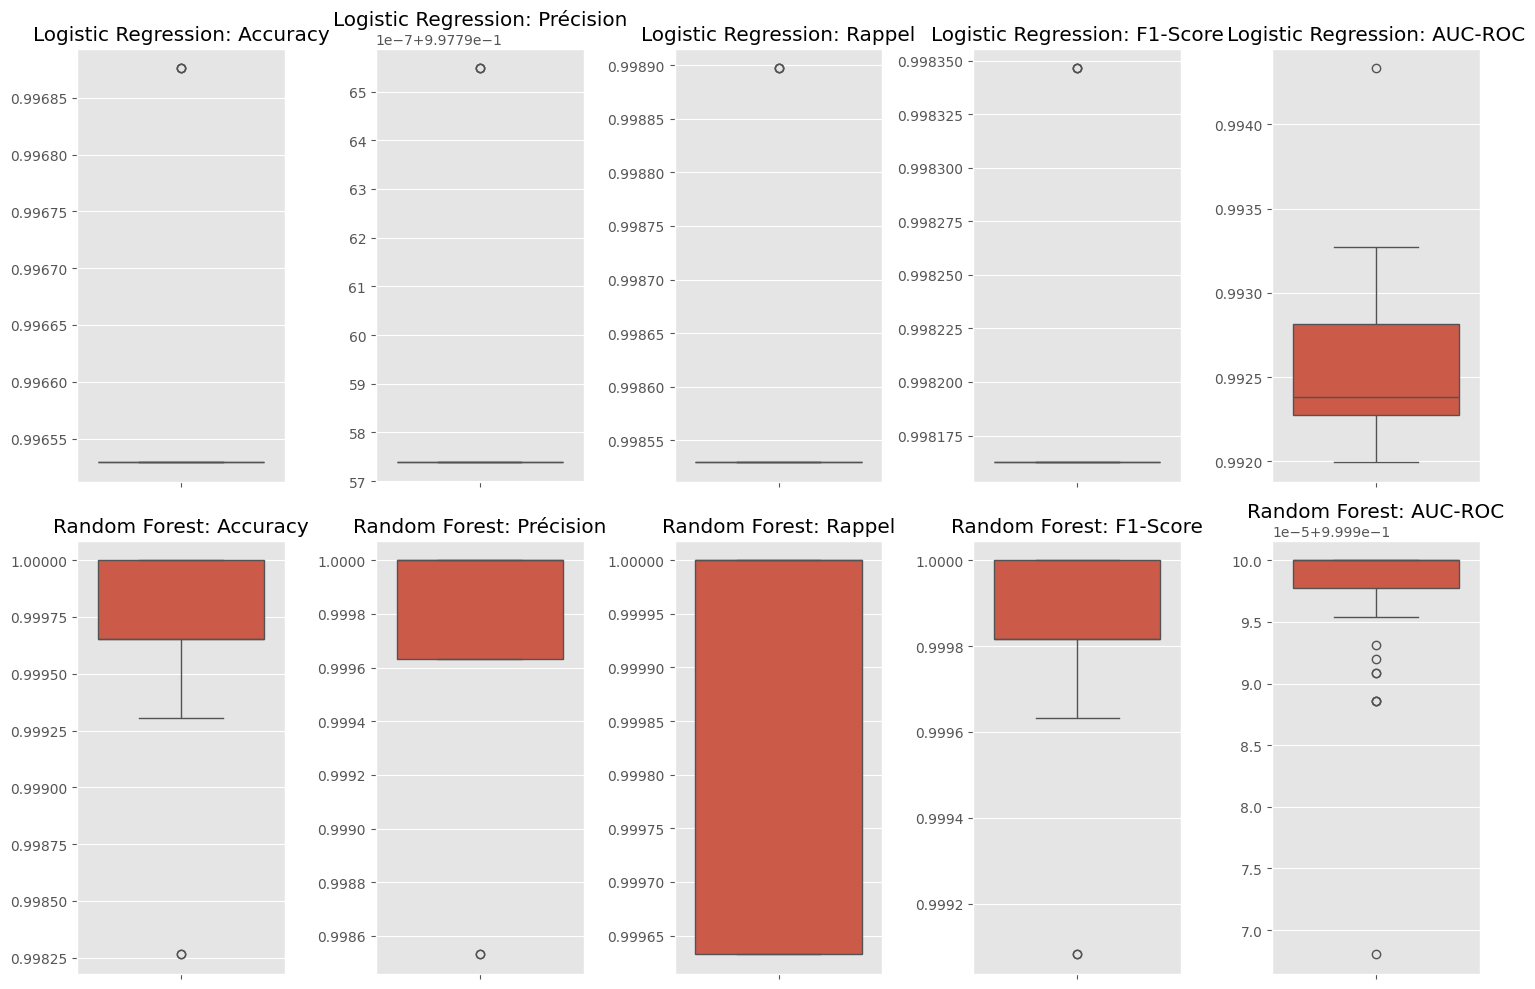

In [4]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Définir le nombre d'échantillons bootstrap ou répétitions
n_iterations = 100

# Préparer les données
label_mapping = {'Fail': 1, 'Success': 0}
train_df_reduced['Anomaly'] = train_df_reduced['Anomaly'].map(label_mapping)
valid_df_reduced['Anomaly'] = valid_df_reduced['Anomaly'].map(label_mapping)

X_train = train_df_reduced.drop(columns=['Timestamp', 'Anomaly'])
y_train = train_df_reduced['Anomaly']
X_valid = valid_df_reduced.drop(columns=['Timestamp', 'Anomaly'])
y_valid = valid_df_reduced['Anomaly']

# Initialiser les listes pour stocker les performances des modèles
metrics_lr = {"accuracy": [], "precision": [], "recall": [], "f1": [], "roc_auc": []}
metrics_rf = {"accuracy": [], "precision": [], "recall": [], "f1": [], "roc_auc": []}

# Boucle principale pour le bootstrap et la modélisation
for _ in range(n_iterations):
    # Créer un échantillon bootstrap
    bootstrap_sample = resample(train_df_reduced, replace=True, n_samples=len(train_df_reduced), random_state=None)
    X_train_bootstrap = bootstrap_sample.drop(columns=['Timestamp', 'Anomaly'])
    y_train_bootstrap = bootstrap_sample['Anomaly']
    
    # Entraîner Logistic Regression
    model_lr = LogisticRegression(solver='saga', max_iter=50000, random_state=None)
    model_lr.fit(X_train_bootstrap, y_train_bootstrap)
    y_pred_lr = model_lr.predict(X_valid)
    y_pred_proba_lr = model_lr.predict_proba(X_valid)[:, 1]
    
    # Calculer les métriques pour Logistic Regression
    metrics_lr["accuracy"].append(accuracy_score(y_valid, y_pred_lr))
    metrics_lr["precision"].append(precision_score(y_valid, y_pred_lr))
    metrics_lr["recall"].append(recall_score(y_valid, y_pred_lr))
    metrics_lr["f1"].append(f1_score(y_valid, y_pred_lr))
    metrics_lr["roc_auc"].append(roc_auc_score(y_valid, y_pred_proba_lr))
    
    # Entraîner Random Forest
    model_rf = RandomForestClassifier(n_estimators=100, random_state=None)
    model_rf.fit(X_train_bootstrap, y_train_bootstrap)
    y_pred_rf = model_rf.predict(X_valid)
    y_pred_proba_rf = model_rf.predict_proba(X_valid)[:, 1]
    
    # Calculer les métriques pour Random Forest
    metrics_rf["accuracy"].append(accuracy_score(y_valid, y_pred_rf))
    metrics_rf["precision"].append(precision_score(y_valid, y_pred_rf))
    metrics_rf["recall"].append(recall_score(y_valid, y_pred_rf))
    metrics_rf["f1"].append(f1_score(y_valid, y_pred_rf))
    metrics_rf["roc_auc"].append(roc_auc_score(y_valid, y_pred_proba_rf))

# Afficher les performances moyennes pour Logistic Regression
print("\nPerformances moyennes pour Logistic Regression:")
for metric, values in metrics_lr.items():
    print(f"{metric.capitalize()} moyenne: {np.mean(values):.4f}")

# Afficher les performances moyennes pour Random Forest
print("\nPerformances moyennes pour Random Forest:")
for metric, values in metrics_rf.items():
    print(f"{metric.capitalize()} moyenne: {np.mean(values):.4f}")

# Visualisation des performances
plt.figure(figsize=(15, 10))

metrics_names = ["accuracy", "precision", "recall", "f1", "roc_auc"]
titles = ['Accuracy', 'Précision', 'Rappel', 'F1-Score', 'AUC-ROC']

for i, metric in enumerate(metrics_names):
    plt.subplot(2, 5, i + 1)
    sns.boxplot(data=metrics_lr[metric])
    plt.title(f'Logistic Regression: {titles[i]}')
    
    plt.subplot(2, 5, i + 6)
    sns.boxplot(data=metrics_rf[metric])
    plt.title(f'Random Forest: {titles[i]}')

plt.tight_layout()
plt.show()


# Évaluation finale sur le test
Appliquer le meilleur modèle sur l'ensemble de test. Calculer la matrice de confusion et des métriques comme l'accuracy, la précision, le rappel, le F1-Score, et l'AUC-ROC.


--- Modèle : Logistic Regression ---
Accuracy sur le test: 0.9969
Précision sur le test: 0.9996
Rappel sur le test: 0.9971
F1-Score sur le test: 0.9984
AUC-ROC sur le test: 0.9999


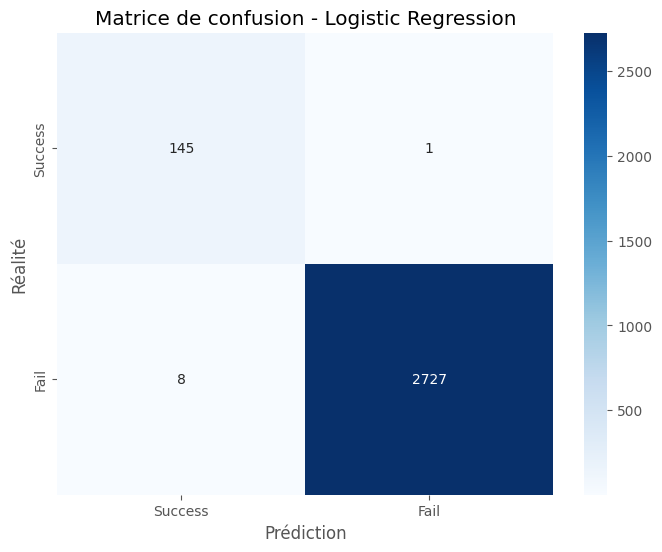

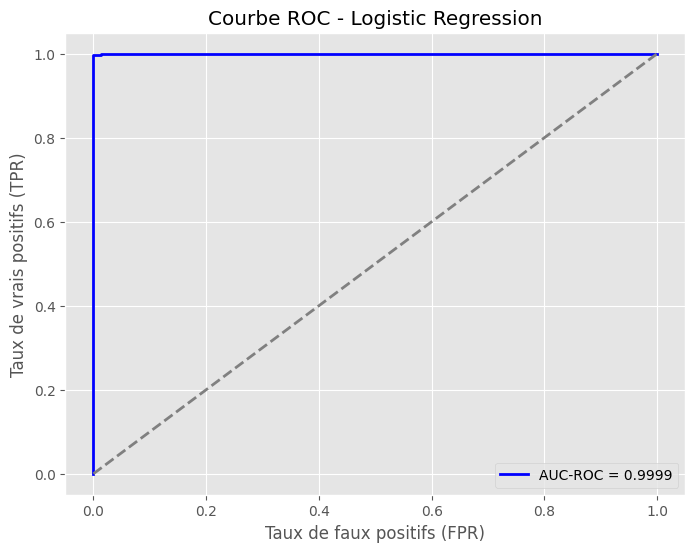


--- Modèle : Random Forest ---
Accuracy sur le test: 0.9997
Précision sur le test: 1.0000
Rappel sur le test: 0.9996
F1-Score sur le test: 0.9998
AUC-ROC sur le test: 1.0000


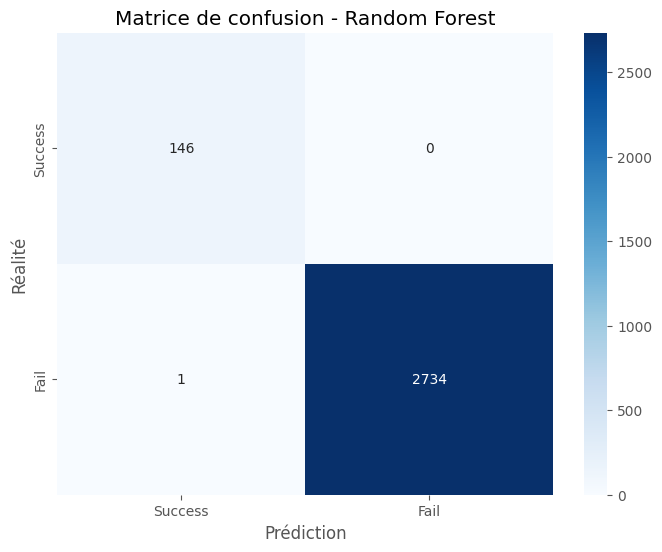

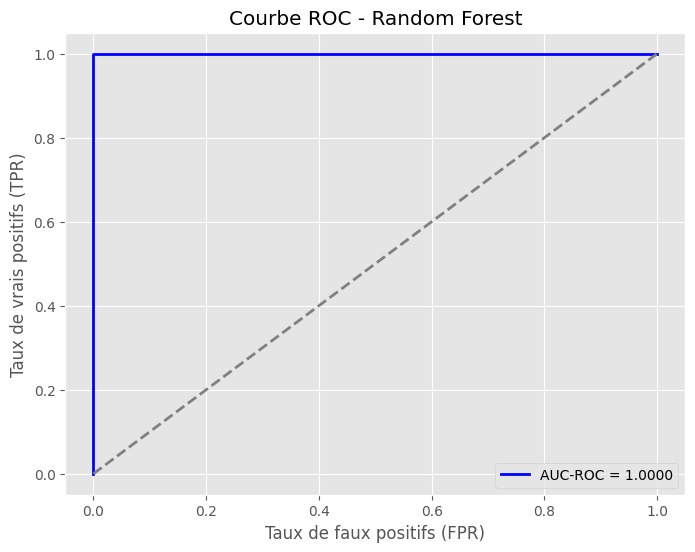


--- Comparaison des performances ---
                     Accuracy  Precision    Recall  F1-Score   AUC-ROC
Logistic Regression  0.996876   0.999633  0.997075  0.998353  0.999945
Random Forest        0.999653   1.000000  0.999634  0.999817  1.000000


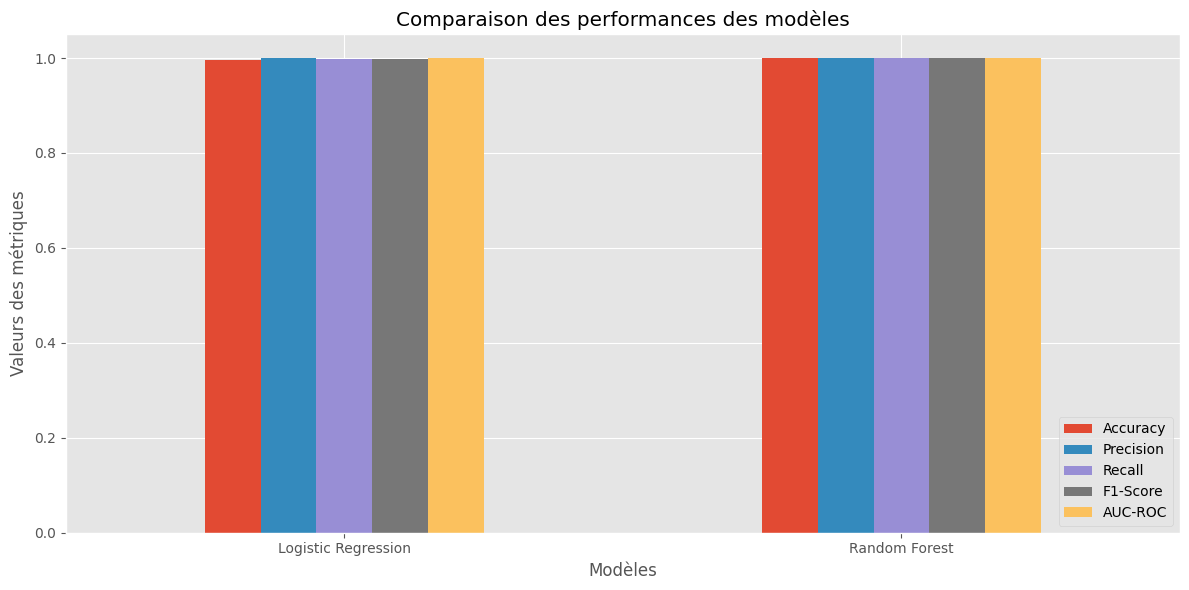

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine training and validation sets
X_train_full = pd.concat([X_train, X_valid])
y_train_full = pd.concat([y_train, y_valid])

# Prepare test set features and target
X_test = test_df_reduced.drop(columns=['Timestamp', 'Anomaly'])
y_test = test_df_reduced['Anomaly']

# Convert y_test to numerical values
label_mapping = {'Fail': 1, 'Success': 0}
y_test = y_test.map(label_mapping)

# Verify the conversion
if y_test.isnull().any():
    raise ValueError("y_test contains NaN values after mapping. Check the data.")

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Store performance metrics
metrics = {}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\n--- Modèle : {model_name} ---")
    # Train the model
    model.fit(X_train_full, y_train_full)

    # Predict on the test set
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate performance metrics
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)
    roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)

    # Store metrics
    metrics[model_name] = {
        "Accuracy": accuracy_test,
        "Precision": precision_test,
        "Recall": recall_test,
        "F1-Score": f1_test,
        "AUC-ROC": roc_auc_test
    }

    # Display performance metrics
    print(f"Accuracy sur le test: {accuracy_test:.4f}")
    print(f"Précision sur le test: {precision_test:.4f}")
    print(f"Rappel sur le test: {recall_test:.4f}")
    print(f"F1-Score sur le test: {f1_test:.4f}")
    print(f"AUC-ROC sur le test: {roc_auc_test:.4f}")

    # Calculate and display the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Success', 'Fail'], yticklabels=['Success', 'Fail'])
    plt.xlabel('Prédiction')
    plt.ylabel('Réalité')
    plt.title(f'Matrice de confusion - {model_name}')
    plt.show()

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC-ROC = {roc_auc_test:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.title(f'Courbe ROC - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Compare the performance metrics of the two models
print("\n--- Comparaison des performances ---")
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

# Visualize the comparison as a bar chart
metrics_df.plot(kind='bar', figsize=(12, 6), rot=0)
plt.title("Comparaison des performances des modèles")
plt.ylabel("Valeurs des métriques")
plt.xlabel("Modèles")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


# Déterminer le meilleur modèle
Les performances des deux modèles sont affichées avec des valeurs pour chaque métrique.

Le modèle avec la meilleure performance globale est identifié et assigné à best_model.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_full, y_train_full)
y_test_pred_lr = lr_model.predict(X_test)
y_test_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_full, y_train_full)
y_test_pred_rf = rf_model.predict(X_test)
y_test_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculer les métriques pour Logistic Regression
lr_metrics = {
    "Accuracy": accuracy_score(y_test, y_test_pred_lr),
    "Precision": precision_score(y_test, y_test_pred_lr),
    "Recall": recall_score(y_test, y_test_pred_lr),
    "F1-Score": f1_score(y_test, y_test_pred_lr),
    "AUC-ROC": roc_auc_score(y_test, y_test_pred_proba_lr)
}

# Calculer les métriques pour Random Forest
rf_metrics = {
    "Accuracy": accuracy_score(y_test, y_test_pred_rf),
    "Precision": precision_score(y_test, y_test_pred_rf),
    "Recall": recall_score(y_test, y_test_pred_rf),
    "F1-Score": f1_score(y_test, y_test_pred_rf),
    "AUC-ROC": roc_auc_score(y_test, y_test_pred_proba_rf)
}

# Comparer les métriques
print("\nPerformances de Logistic Regression:")
for metric, value in lr_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nPerformances de Random Forest:")
for metric, value in rf_metrics.items():
    print(f"{metric}: {value:.4f}")

# Décider du modèle avec la meilleure performance globale (exemple basé sur AUC-ROC)
if lr_metrics["AUC-ROC"] > rf_metrics["AUC-ROC"]:
    print("\nLogistic Regression a performé le mieux selon AUC-ROC.")
    best_model = lr_model  # Assigner Logistic Regression comme meilleur modèle
else:
    print("\nRandom Forest a performé le mieux selon AUC-ROC.")
    best_model = rf_model  # Assigner Random Forest comme meilleur modèle



Performances de Logistic Regression:
Accuracy: 0.9969
Precision: 0.9996
Recall: 0.9971
F1-Score: 0.9984
AUC-ROC: 0.9999

Performances de Random Forest:
Accuracy: 0.9997
Precision: 1.0000
Recall: 0.9996
F1-Score: 0.9998
AUC-ROC: 1.0000

Random Forest a performé le mieux selon AUC-ROC.


# Interprétation du modèle AiOps


Comparaison des importances des variables :
    Variable  Importance_LogisticRegression  Importance_RandomForest
0         E9                   4.654495e+00                 0.011905
1        E84                   4.148975e+00                 0.015788
2         E8                   3.089081e+00                 0.018266
3        E12                   2.729443e+00                 0.002366
4        E16                   2.661717e+00                 0.006402
..       ...                            ...                      ...
120     E245                   7.776580e-06                 0.000000
121     E242                   6.779945e-06                 0.000000
122     E144                   2.282638e-06                 0.000059
123      E70                   2.251852e-07                 0.000000
124     E209                   4.980967e-08                 0.000000

[125 rows x 3 columns]


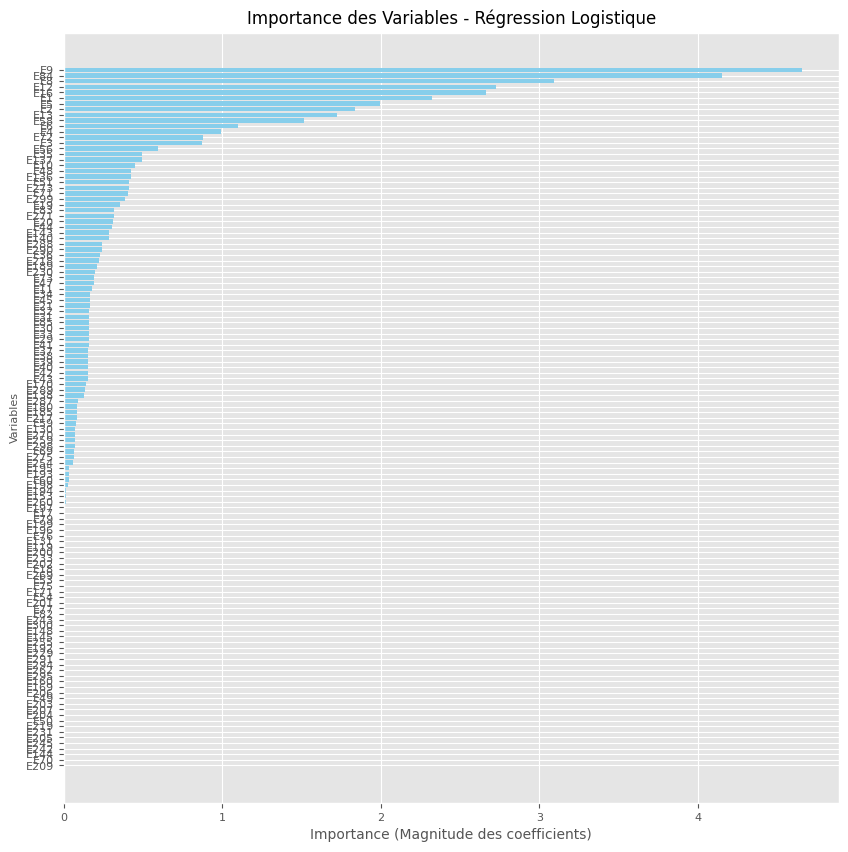

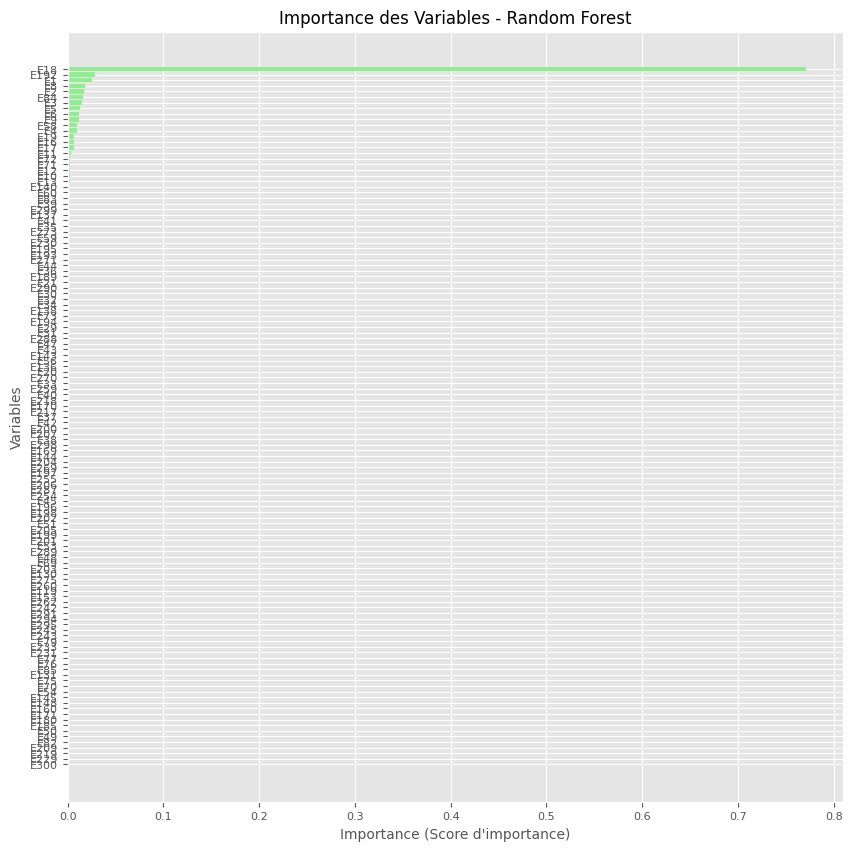

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Entraîner un modèle Logistic Regression
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_full, y_train_full)

# Extraire les coefficients pour Logistic Regression
coefficients = log_model.coef_[0]  # Coefficients du modèle Logistic Regression
feature_names = X_train_full.columns  # Noms des variables dans l'ensemble combiné

# Calculer l'importance des variables pour Logistic Regression
logistic_importances = pd.DataFrame({
    'Variable': feature_names,
    'Importance': np.abs(coefficients)  # Valeurs absolues des coefficients
}).sort_values(by='Importance', ascending=False)

# Entraîner un modèle Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_full, y_train_full)

# Calculer l'importance des variables pour Random Forest
rf_importances = pd.DataFrame({
    'Variable': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Comparaison des importances
comparison = logistic_importances.merge(
    rf_importances, on='Variable', suffixes=('_LogisticRegression', '_RandomForest')
)

# Afficher la comparaison
print("\nComparaison des importances des variables :")
print(comparison)

# Exporter la comparaison dans un fichier CSV
comparison.to_csv('BGL_results/BGL_1M_comparison_importances.csv', index=False)

# Visualisation des importances pour Logistic Regression
plt.figure(figsize=(10, 10))
plt.barh(logistic_importances['Variable'], logistic_importances['Importance'], color='skyblue')
plt.xlabel('Importance (Magnitude des coefficients)', fontsize=10)
plt.ylabel('Variables', fontsize=8)
plt.title('Importance des Variables - Régression Logistique', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.gca().invert_yaxis()
plt.show()

# Visualisation des importances pour Random Forest
plt.figure(figsize=(10, 10))
plt.barh(rf_importances['Variable'], rf_importances['Importance'], color='lightgreen')
plt.xlabel('Importance (Score d\'importance)', fontsize=10)
plt.ylabel('Variables', fontsize=10)
plt.title('Importance des Variables - Random Forest', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.gca().invert_yaxis()
plt.show()


In [10]:
# Exporter la liste des variables importantes dans un fichier CSV
logistic_importances.to_csv('BGL_results/BGL_1M_LR_importances.csv', index=False)
rf_importances.to_csv('BGL_results/BGL_1M_RF_importances.csv', index=False)